In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

In [2]:
# Load the CSV file to inspect its structure
file_path = "Metrics.csv"
df = pd.read_csv(file_path, skiprows=[8, 9])
df['Metrics'] = df['Metrics'].apply(lambda x: x.rstrip())
df.head()

,Metrics,DWA,SCL,RRT Star,MCTS + RL,Units
0,time to reach goal,4.80,5.10,4.90,12.40,s
1,path length,29.50,31.10,30.70,32.40,m
2,avg dist to closest person,6.36,7.95,7.26,8.12,m
3,min dist to people,0.41,0.94,0.49,1.18,m
4,intimate space intrusions,3.66,0.00,3.13,0.00,%


In [3]:
col_list = [item.rstrip() for item in df.columns.tolist()]
metrics_list = [item.rstrip() for item in df['Metrics'].tolist()]
print(col_list)
print(metrics_list)

['Metrics', 'DWA', 'SCL', 'RRT Star', 'MCTS + RL', 'Units']
['time to reach goal', 'path length', 'avg dist to closest person', 'min dist to people', 'intimate space intrusions', 'personal space intrusions', 'social+ space intrusions', 'time not moving']


In [4]:
# Define metric categories
navigation_metrics = ["time to reach goal", 
                      "path length", 
                      "time not moving"
                      ]
social_metrics = ["avg dist to closest person", 
                  "min dist to people", 
                  "intimate space intrusions",
                  "personal space intrusions",
                  "social+ space intrusions",
                  ]
better_is_lower = ["time to reach goal", 
                   "path length", 
                   "time not moving", 
                   "intimate space intrusions", 
                   "personal space intrusions"
                   ]
better_is_higher = ["avg dist to closest person", 
                    "min dist to people", 
                    "social+ space intrusions"
                    ]

In [5]:
def normalize_metric_df(df, better_is_higher, better_is_lower):
    # Keep a copy of the 'Metrics' column and drop 'Units'
    metrics_col = df['Metrics']
    df_numeric = df.drop(columns=["Metrics", "Units"]).copy()

    # Prepare the normalized DataFrame
    normalized_df = pd.DataFrame(index=metrics_col, columns=df_numeric.columns)

    # Normalize "better is higher" metrics
    for metric in better_is_higher:
        min_val = df_numeric.loc[metrics_col == metric].min().min()
        max_val = df_numeric.loc[metrics_col == metric].max().max()
        row = df_numeric.loc[metrics_col == metric].squeeze()
        normalized_df.loc[metric] = 1.0 if max_val == min_val else (row - min_val) / (max_val - min_val)

    # Normalize "better is lower" metrics
    for metric in better_is_lower:
        min_val = df_numeric.loc[metrics_col == metric].min().min()
        max_val = df_numeric.loc[metrics_col == metric].max().max()
        row = df_numeric.loc[metrics_col == metric].squeeze()
        normalized_df.loc[metric] = 1.0 if max_val == min_val else (max_val - row) / (max_val - min_val)

    # Reset index and re-add Metrics as a column
    normalized_df = normalized_df.reset_index()
    normalized_df.rename(columns={'index': 'Metrics'}, inplace=True)

    return normalized_df


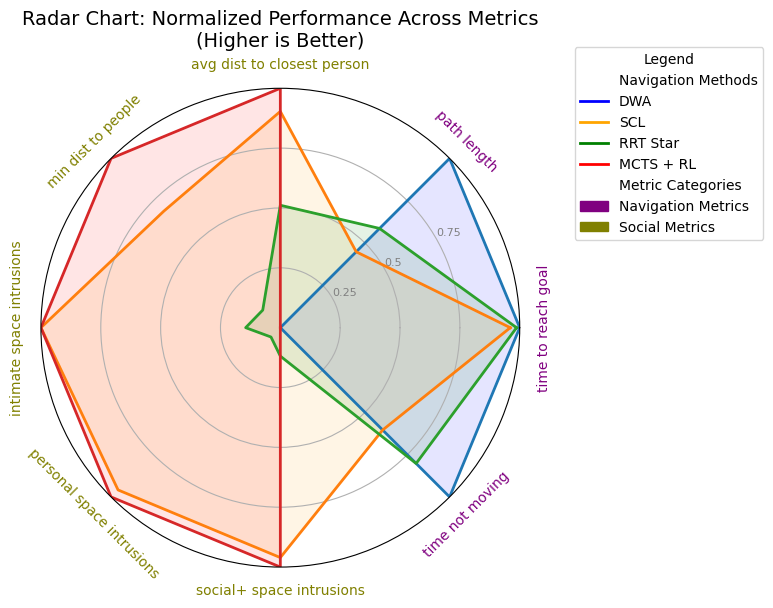

In [6]:
# Make a copy of the data to normalize it for radar chart
df_radar = normalize_metric_df(df, better_is_higher, better_is_lower)

num_vars = len(metrics_list) 

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Get values for each planner
planners = ["DWA", "SCL", "RRT Star", "MCTS + RL"]
planner_data = {}

for planner in planners:
    values = df_radar[planner].astype(float).tolist()
    values += values[:1]  # complete the loop
    planner_data[planner] = values

# Plot radar chart
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels with colors
for i, (angle, label) in enumerate(zip(angles[:-1], df_radar['Metrics'])):
    if label.rstrip() in navigation_metrics:
        color = 'purple'
    elif label.rstrip() in social_metrics:
        color = 'olive'
    else:
        color = 'grey'
    
    angle_deg = np.degrees(angle)
    
    # Adjust text rotation based on angle
    if angle_deg == 0 or angle_deg == 180:
        rotation = 90  
        va = 'center'
    elif angle_deg > 180:
        rotation = angle_deg + 90
        va = 'center'
    else:
        rotation = angle_deg - 90
        va = 'center'
        
    ax.text(angle, 1.1, label, color=color, size=10, ha='center', va=va, rotation=rotation, rotation_mode='anchor')

# Draw ylabels
ax.set_rlabel_position(30)
ax.set_xticks([])
plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=8)
plt.ylim(0, 1)

# Plot data for each planner
colors = ['blue', 'orange', 'green', 'red']
for planner, color in zip(planners, colors):
    ax.plot(angles, planner_data[planner], linewidth=2, linestyle='solid', label=planner)
    ax.fill(angles, planner_data[planner], alpha=0.1, color=color)

# Add title
plt.title("Radar Chart: Normalized Performance Across Metrics\n(Higher is Better)", size=14, pad=30)

# Create both legends

# Section header placeholders (invisible, but labeled)
section_header_planners = Line2D([], [], color='none', label='Navigation Methods')
section_header_metrics = Line2D([], [], color='none', label='Metric Categories')

category_legend_elements = [
    Patch(facecolor='purple', edgecolor='purple', label='Navigation Metrics'),
    Patch(facecolor='olive', edgecolor='olive', label='Social Metrics')
]

method_legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='DWA'),
    Line2D([0], [0], color='orange', lw=2, label='SCL'),
    Line2D([0], [0], color='green', lw=2, label='RRT Star'),
    Line2D([0], [0], color='red', lw=2, label='MCTS + RL')
]

# Combine them with headers
custom_legend = [section_header_planners] + method_legend_elements + [section_header_metrics] + category_legend_elements

# Add the custom combined legend
ax.legend(handles=custom_legend, loc='upper left', bbox_to_anchor=(1.1, 1.1), frameon=True, title="Legend")

plt.tight_layout()
plt.show()

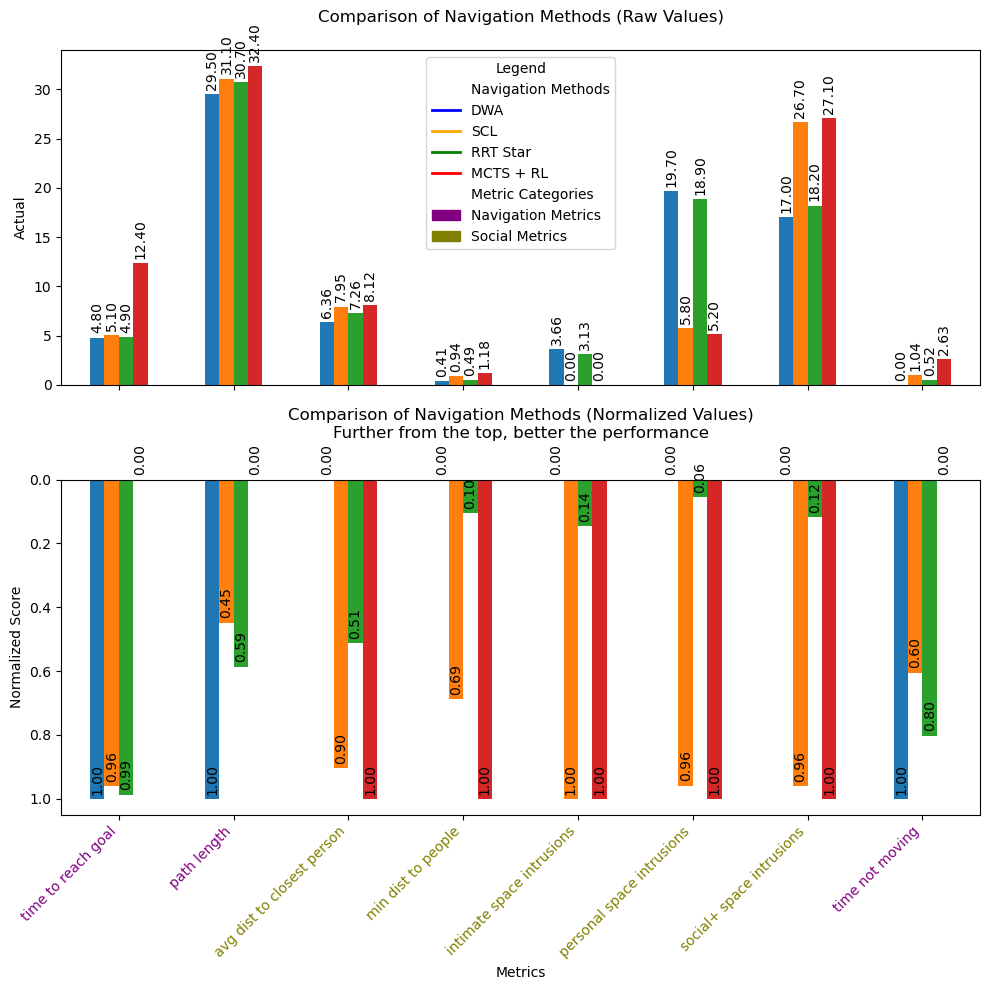

In [9]:
# Create figure with a good size
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 1]})

# Plot raw values (Actual values - upward)
df_plot = df.set_index('Metrics').drop('Units', axis=1)
df_plot.plot(kind='bar', ax=ax1)
ax1.set_title('Comparison of Navigation Methods (Raw Values)', pad=20)
ax1.set_ylabel("Actual", rotation=90)
ax1.yaxis.set_label_position("left")
#ax1.get_legend().remove()

# Add value labels on the bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3, rotation=90)


# Normalize values between 0 and 1, adjusting for directionality
df_normalized = normalize_metric_df(df, better_is_higher, better_is_lower)

df_normalized.plot(kind='bar', ax=ax2)
ax2.set_title('Comparison of Navigation Methods (Normalized Values)\nFurther from the top, better the performance', pad=30)
ax2.set_ylabel("Normalized Score", rotation=90)
ax2.yaxis.set_label_position("left")
ax2.get_legend().remove()

# Add value labels on the normalized bars with rotation
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', padding=3, rotation=90)

# Invert the y-axis for downward plot
ax2.invert_yaxis()

# Set shared x-axis labels

# Get the metric labels
metric_labels = df['Metrics']
ax2.set_xticklabels(metric_labels, rotation=45, ha='right')
ax2.set_xlabel("Metrics")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Color the x-axis labels based on metric category
for i, label in enumerate(ax2.get_xticklabels()):
    if label.get_text().rstrip() in navigation_metrics:
        label.set_color('purple')
    elif label.get_text().rstrip() in social_metrics:
        label.set_color('olive')


# Section header placeholders (invisible, but labeled)
section_header_planners = Line2D([], [], color='none', label='Navigation Methods')
section_header_metrics = Line2D([], [], color='none', label='Metric Categories')

category_legend_elements = [
    Patch(facecolor='purple', edgecolor='purple', label='Navigation Metrics'),
    Patch(facecolor='olive', edgecolor='olive', label='Social Metrics')
]

method_legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='DWA'),
    Line2D([0], [0], color='orange', lw=2, label='SCL'),
    Line2D([0], [0], color='green', lw=2, label='RRT Star'),
    Line2D([0], [0], color='red', lw=2, label='MCTS + RL')
]

# Combine them with headers
custom_legend = [section_header_planners] + method_legend_elements + [section_header_metrics] + category_legend_elements

# Add the custom combined legend
ax1.legend(handles=custom_legend, loc='best', title="Legend")


# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()